In [1]:
import numpy as np
import pandas as pd
import joblib
import datetime
import matplotlib.pyplot as plt
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from hyperopt import hp, anneal, Trials, STATUS_OK
from hyperopt.fmin import fmin
from functools import partial

In [2]:
# Load the datasets
train_df = pd.read_excel("train_data.xlsx")
test_df = pd.read_excel("test_data.xlsx")

In [3]:
# Define features (X) and target (y) for training and testing
X_train = train_df.drop(['P'], axis=1)
y_train = train_df['P']
X_test = test_df.drop(['P'], axis=1)
y_test = test_df['P']


In [4]:
def model_metrics(model, X, y):
    """Compute R2 score for model evaluation."""
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

def bayes_fmin(X_train, X_test, y_train, y_test, eval_iters=100):
    """Hyperparameter optimization using Bayesian search."""
    def objective(params):
        model = ExtraTreeRegressor(
            max_depth=int(params['max_depth']),
            max_features=int(params['max_features']),
            min_samples_split=int(params['min_samples_split']),
            min_samples_leaf=int(params['min_samples_leaf']),
            random_state=42
        )
        model.fit(X_train, y_train)
        loss = -model_metrics(model, X_test, y_test)
        return {"loss": loss, "status": STATUS_OK}

    space = {
        'max_depth': hp.quniform('max_depth', 1, 50, 1),
        'max_features': hp.quniform('max_features', 1, 3, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 30, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 30, 1),
    }
    best_params = fmin(objective, space, algo=partial(anneal.suggest), max_evals=eval_iters, trials=Trials())
    best_params = {key: int(value) for key, value in best_params.items()}
    return best_params

In [5]:
# Hyperparameter tuning
best_params = bayes_fmin(X_train, X_test, y_train, y_test, 500)
print("Best Hyperparameters:", best_params)

100%|██████████| 500/500 [00:04<00:00, 108.36trial/s, best loss: -0.915358732101572]
Best Hyperparameters: {'max_depth': 45, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 19}


In [6]:
# Train ExtraTreeRegressor model
model = ExtraTreeRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)


ExtraTreeRegressor(max_depth=45, max_features=2, min_samples_split=19,
                   random_state=42)

In [7]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [8]:

# Model Evaluation
metrics = {
    "RMSE_Train": np.sqrt(mean_squared_error(y_train, y_train_pred)),
    "MAE_Train": mean_absolute_error(y_train, y_train_pred),
    "R2_Train": r2_score(y_train, y_train_pred),
    "RMSE_Test": np.sqrt(mean_squared_error(y_test, y_test_pred)),
    "MAE_Test": mean_absolute_error(y_test, y_test_pred),
    "R2_Test": r2_score(y_test, y_test_pred)
}

for key, value in metrics.items():
    print(f"{key}: {value:.4f}")




def compute_bic(model, X, y):
    """Compute BIC for the model."""
    n = len(y)  # Number of data points
    k = len(model.get_params())  # Number of parameters (hyperparameters)
    y_pred = model.predict(X)
    rss = np.sum((y - y_pred) ** 2)  # Residual sum of squares (RSS)

    bic = n * np.log(rss / n) + k * np.log(n)
    return bic

# Compute BIC for Train and Test
bic_train = compute_bic(model, X_train, y_train)
bic_test = compute_bic(model, X_test, y_test)

# Print the BIC values
print(f"BIC (Train Data): {bic_train:.4f}")
print(f"BIC (Test Data): {bic_test:.4f}")

RMSE_Train: 37.7066
MAE_Train: 21.9796
R2_Train: 0.9524
RMSE_Test: 47.4068
MAE_Test: 27.7461
R2_Test: 0.9154
BIC (Train Data): 22594.1920
BIC (Test Data): 10342.9048


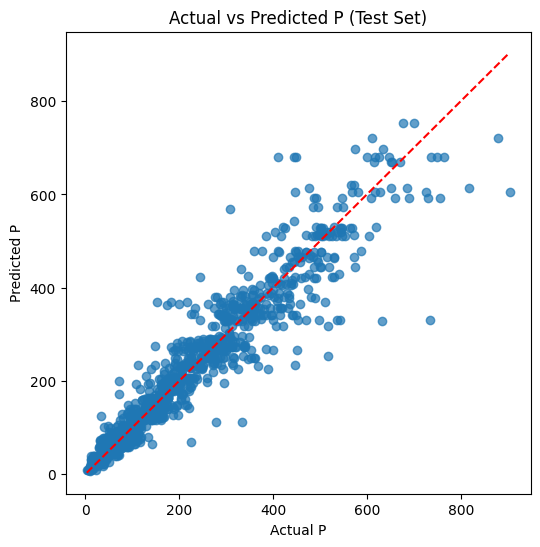

In [9]:
# Scatter plot of True vs Predicted values for Test set
plt.figure(figsize=(6, 6))
plt.scatter(y_test, model.predict(X_test), alpha=0.7)
plt.xlabel("Actual P")
plt.ylabel("Predicted P")
plt.title("Actual vs Predicted P (Test Set)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 1:1 line
plt.show()


Save the trained  model to a file using joblib.



In [10]:
joblib.dump(model, 'extratreeboost_model.pkl')

['extratreeboost_model.pkl']

:
Calculate the residuals, create a residual plot, and create a histogram of the residuals to evaluate the model's performance on the test set.



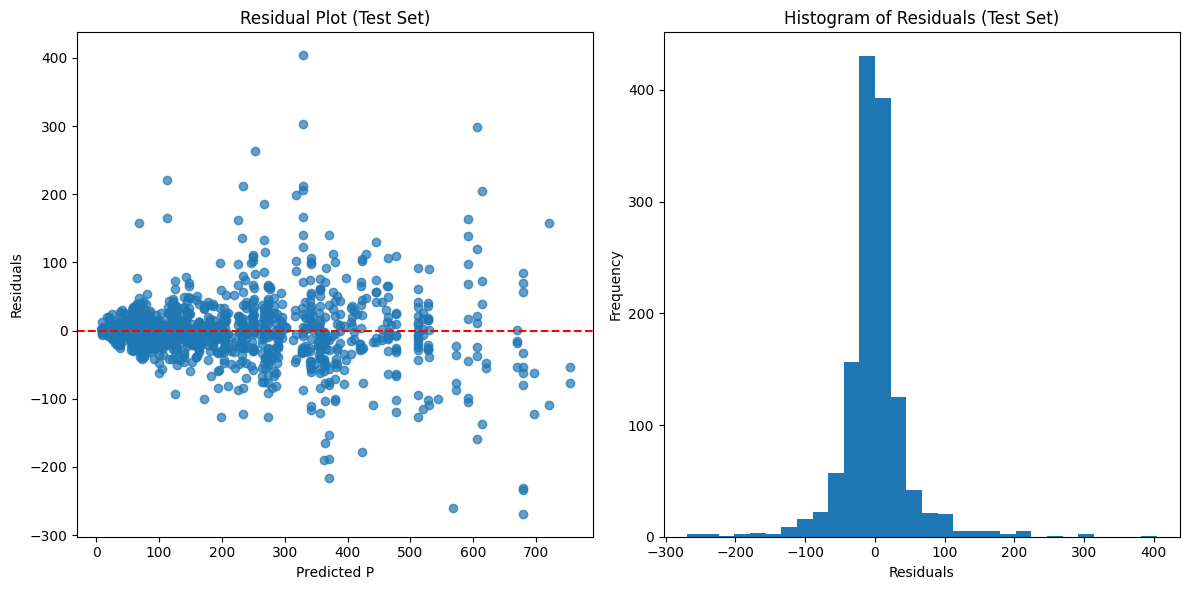

In [11]:
# Calculate residuals
residuals = y_test - y_test_pred

# Create residual plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_pred, residuals, alpha=0.7)
plt.xlabel("Predicted P")
plt.ylabel("Residuals")
plt.title("Residual Plot (Test Set)")
plt.axhline(y=0, color='r', linestyle='--')

# Create histogram of residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals (Test Set)")

plt.tight_layout()
plt.show()

## Predict on new data


Create some sample new data and use the trained model to make predictions.


**Reasoning**:
Create sample new data and use the trained model to make predictions.



In [12]:
# Create sample new data
new_data = pd.DataFrame({
    'FH': [15.0, 18.0, 12.0],
    'DT': [0.5, 1.0, 0.3],
    'EH': [10.0, 15.0, 8.0],
    'LT': [2.5, 3.0, 2.0],
    'CD': [6.0, 7.0, 5.0],
    'TC': [30.0, 40.0, 25.0],
    'MT': [500.0, 700.0, 300.0]
})



In [16]:
# Predict on new data
new_predictions = model.predict(new_data)

# Print the predicted values
print("Predicted P for new data:")
print(new_predictions)

Predicted P for new data:
[ 99.19266667 152.23538462  65.39      ]


## Summary:

### Data Analysis Key Findings

*   The trained AdaBoost model was successfully saved to a file named `extratreeboost_model.pkl`.
*   Residual plots and histograms of residuals were generated to visually evaluate the model's performance on the test set.
*   The trained model was used to predict the target variable 'P' on a sample of new data, and the predicted values were displayed.

### Way forward

*   Analyzing the residual plot and histogram of residuals can provide insights into the model's error distribution and potential areas for improvement.
*   The ability to save and load the model allows for its deployment and use on new, unseen data.
